# Transfer Learning with VGG & ResNet and Cats vs. Dogs dataset
<hr>

## 1. Prepare & Explore Dataset

In [1]:
# import pachages 
from tensorflow import keras 
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical 
from keras.applications import VGG19, ResNet50
from keras.optimizers import SGD, Adam

In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    directory='dogs-vs-cats/train/',
    labels='inferred',
    label_mode='categorical',    
    batch_size=32,
    image_size=(160, 160),
    validation_split=0.1,
    subset="training",
    seed=1024
)

val_ds = image_dataset_from_directory(
    directory='dogs-vs-cats/train/',
    labels='inferred',
    label_mode='categorical',    
    batch_size=32,
    image_size=(160, 160),
    validation_split=0.1,
    subset="validation",
    seed=1024
)

Found 25000 files belonging to 2 classes.
Using 22500 files for training.
Found 25000 files belonging to 2 classes.
Using 2500 files for validation.


In [5]:
class_names = val_ds.class_names

In [6]:
class_names

['cat', 'dog']

In [4]:
print(train_ds)
print(val_ds)
print(class_names)

<BatchDataset shapes: ((None, 160, 160, 3), (None, 2)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 160, 160, 3), (None, 2)), types: (tf.float32, tf.float32)>
['cat', 'dog']


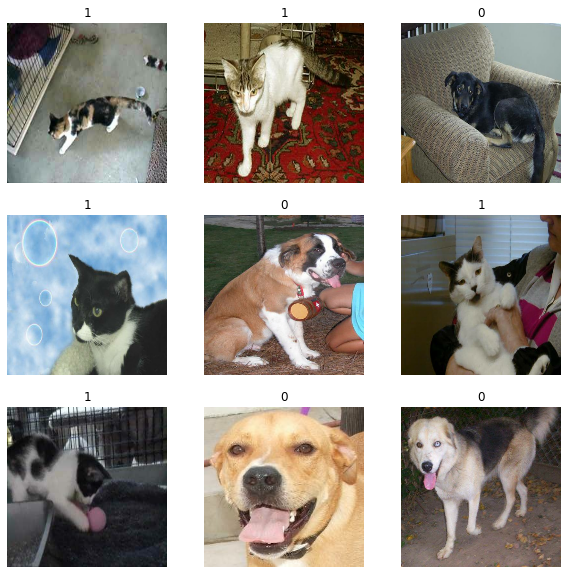

In [5]:
#Visualize the data

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):       
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(list(labels[i])[0]))
        plt.axis("off")

We can now begin the actual process of model building.
The following a set process and following consistently makes learning this easier :

- Define the Data Augmentation (ImageDataGenerator) 
- Build the model (Base Model + Flatten + Dense)
- Check model summary
- Initialize Batch Size,Number of Epochs
- Compile model
- Fit the model 
- Evaluate the model 

## 2. Define the neural network architecture

In [8]:
# define the CNN model
'The first base model used is VGG19. The pretrained weights from the imagenet challenge are used'
base_model_1 = VGG19(include_top=False, weights='imagenet', input_shape=(160,160,3), classes=class_names)

In [9]:
#Lets add the final layers to these base models where the actual classification is done in the dense layers
model_1 = Sequential()
model_1.add(base_model_1) 
model_1.add(Flatten()) 

In [10]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 5, 5, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


In [11]:
#Add the Dense layers along with activation and batch normalization
model_1.add(Dense(1024,activation=('relu'),input_dim=512))
model_1.add(BatchNormalization())
model_1.add(Dense(512,activation=('relu'))) 
model_1.add(BatchNormalization())
model_1.add(Dense(256,activation=('relu'))) 
model_1.add(BatchNormalization())
model_1.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model_1.add(Dense(128,activation=('relu')))
model_1.add(BatchNormalization())
model_1.add(Dropout(.2))
model_1.add(Dense(2, activation=('softmax'))) #This is the classification layer

In [12]:
#Check final model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 5, 5, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              13108224  
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1

## 3. Compile the neural net

In [13]:
# compile your model
model_1.compile(loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])

In [14]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## 4. Fit / train the neural net

In [15]:
callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),]
model_1.fit(train_ds, validation_data = val_ds, callbacks=callbacks, epochs = 5) 

Epoch 1/5
704/704 [==============================] - 5211s 7s/step - loss: 0.7482 - accuracy: 0.5727 - val_loss: 1055687.0000 - val_accuracy: 0.5284
Epoch 2/5
704/704 [==============================] - 5020s 7s/step - loss: 0.5883 - accuracy: 0.6941 - val_loss: 4323287.5000 - val_accuracy: 0.6888
Epoch 3/5
704/704 [==============================] - 5267s 7s/step - loss: 0.4863 - accuracy: 0.7732 - val_loss: 0.4019 - val_accuracy: 0.8156
Epoch 4/5
704/704 [==============================] - 5215s 7s/step - loss: 0.4073 - accuracy: 0.8184 - val_loss: 794.2145 - val_accuracy: 0.8124
Epoch 5/5
704/704 [==============================] - 4965s 7s/step - loss: 0.3076 - accuracy: 0.8688 - val_loss: 0.3117 - val_accuracy: 0.8780


## 5. Evaluate the neural net

In [16]:
score = model_1.evaluate(val_ds, verbose=1) 
print('Validation accuracy:', score[1]) 

79/79 [==============================] - 121s 2s/step - loss: 0.3117 - accuracy: 0.8780
Validation accuracy: 0.878000020980835


<hr>

# Define model_2 using ResNet

In [6]:
# define the CNN model
'For the 2nd base model we will use Resnet 50 and compare the performance against the previous one'
'The hypothesis is that Resnet 50 should perform better because of its deeper architecture'
base_model_2 = ResNet50(include_top=False, weights='imagenet', input_shape=(160,160,3), classes=class_names)

#Lets add the final layers to these base models where the actual classification is done in the dense layers
model_2 = Sequential()
model_2.add(base_model_2)
model_2.add(Flatten())

#Add the Dense layers along with activation and batch normalization
model_2.add(Dense(1024, activation=('relu'), input_dim=512))
model_2.add(BatchNormalization())
model_2.add(Dense(512,activation=('relu')))
model_2.add(BatchNormalization())
model_2.add(Dense(256,activation=('relu'))) 
model_2.add(BatchNormalization())
model_2.add(Dropout(.3))
model_2.add(Dense(128,activation=('relu')))
model_2.add(BatchNormalization())
model_2.add(Dropout(.2))
model_2.add(Dense(2, activation=('softmax'))) #This is the classification layer

model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              52429824  
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1

In [7]:
model_2.compile(loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['accuracy'])
callbacks = [keras.callbacks.ModelCheckpoint("model_2_save_at_{epoch}.h5"),]
model_2.fit(train_ds, validation_data = val_ds, callbacks=callbacks, epochs = 5)

Epoch 1/5
704/704 [==============================] - 3331s 5s/step - loss: 0.6972 - accuracy: 0.6238 - val_loss: 0.7290 - val_accuracy: 0.6032
Epoch 2/5
704/704 [==============================] - 3281s 5s/step - loss: 0.6265 - accuracy: 0.6480 - val_loss: 0.5622 - val_accuracy: 0.7056
Epoch 3/5
704/704 [==============================] - 3197s 5s/step - loss: 0.4450 - accuracy: 0.7943 - val_loss: 4.4500 - val_accuracy: 0.4900
Epoch 4/5
704/704 [==============================] - 3192s 5s/step - loss: 0.3323 - accuracy: 0.8473 - val_loss: 0.3709 - val_accuracy: 0.8528
Epoch 5/5
704/704 [==============================] - 3204s 5s/step - loss: 0.2511 - accuracy: 0.8874 - val_loss: 0.5892 - val_accuracy: 0.6984


In [8]:
score = model_2.evaluate(val_ds, verbose=1) 
print('Validation accuracy:', score[1]) 

79/79 [==============================] - 60s 753ms/step - loss: 0.5892 - accuracy: 0.6984
Validation accuracy: 0.6984000205993652


<hr>